# Classification




## Description

For this project we'll be building a number of classification machine learning models and see how they perform on the famous MNIST dataset. **WARNING: this whole jupyter notebook can take over an hour to run but that is mostly just the last two cells.** 

### Setup

Some basic setup things to get started.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Fetch Data

This project will work on the MNIST dataset. It is a set of data that comes with sklearn already and basically consists of handwritten numbers 0-9. These numbers were written by highschool kids and maybe some census employees. It is often called the "Hello World" of Machine Learning. There are 70,000 images (rows) each consisting of 784 features (columns). This dataset is fairly large so fair warning running this notebook might take some time here and there. 

The following code fetches this data from sklearn open datasets and shows the shape and an example image.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
np.sqrt(784)

28.0

Saving figure some_digit_plot


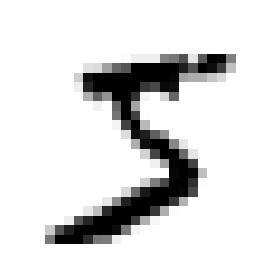

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

### Training a Binary Classifier

First we'll break the dataset into test and train. Sklearn already splits it properly so all we need to do is assign the data to our variables. The dataset uses 60,000 as the train set and the remaining 10,000 is the test set. 

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
y_train_5 = (y_train ==5)
y_test_5 = (y_test ==5)

For the first binary classifier we'll use the SGD Classifier (Stochastic Gradient Descent). This model has an advantage of being pretty speedy so it is a great one to use on larger datasets.

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now that we have created this model let's test it out on some_digit from earlier.

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy using Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In this example: 
* 53892 results correctly classified as non 5's (true negative)
* 687 results wrongly classified as 5's (false positives)
* 1891 results wrongly classified as non 5's (false negatives)
* 3520 results correctly classified as 5's (true positives)
    
A perfect matrix would look like:

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In this example of a perfect solution:

* 54579 results correctly classified as non 5's (true negative)
* 0 results wrongly classified as 5's (false positives)
* 5421 results wrongly classified as non 5's (false negatives)
* 0 results correctly classified as 5's (true positives)

### Precision vs Recall

A more concise way of showing this metric is the *precision* of the classifier. This is derived by:

> precision = TP / ( TP + FP)

TP is the number of true positives and FP is false positives. Precision is typically used alongside another metric called the *recall*, also known as *sensitivity* also known as *true positive rate*. This is derived by:

> recall = TP / (TP + FN)

sklearn.metrics has functions to calculate both of these metrics which we'll demonstrate here.

In [17]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


So when this model claims to have a 5 it is correct 84% of the time and only detects 65% of the 5s in the training set. 

We can combine the precision and recall scores into one metric called the F1 score (Fsubscript1). The F1 score is often the *Harmonic Mean* of precision and recall. This means it will give more weight to the low values. Therefore to have a high F1 score both the precision and recall scores must be high. The equation is as follows:

> F1 =  2 * (precision * recall) / (precision + recall)

In other words:

> F1 = TP / (TP + ((FN + FP)/2))

To calculate the F1 score we can simply call the function from sklearn.

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade Off

The precision recall trade off refers to the idea that these two measures are negatively correlated. Increasing the precision will decrease the recall and vice versa. Raising the threshold decreases the recall. To decide what threshold to use... 

Below is the process for choosing a threshold value.

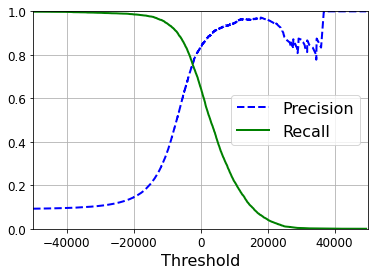

In [22]:
# Call predict and change method to decision function
# This gets the scores of all instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

# Use the precision_recall_curve() to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Plot precision and recall as functions of the threshold value 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

As we can see the crossover point occurs on a negative threshold and that may be the ideal spot to maximize both the precision and recall scores. However sometimes you may want a higher precision score or higher recall score depending on the use case. For example it may be more impactful to get some classifications wrong rather than getting more right etc so use with care. Another way for us to calculate a good precision recall trade off is to plot precision directly against recall. Code to do that shown below.

Saving figure precision_vs_recall_plot


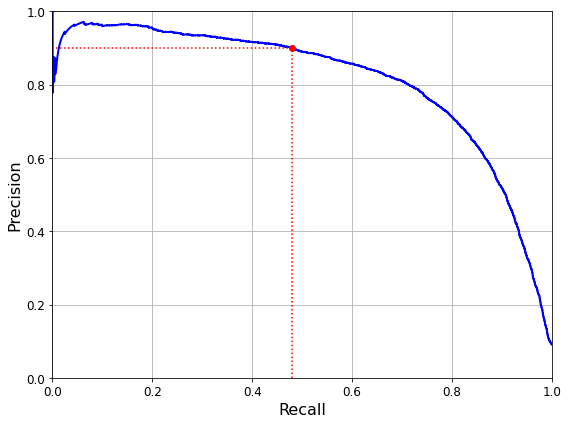

In [24]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In this graph we can see that the precision scores drop off pretty hard at 0.5-0.6 range so ideally we should choose a point before that. Again the choice depends on what the project needs and how important false positives and false negatives etc are to the project at hand. Say one chooses to have a 90% precision this is how they would calculate the values needed to achieve that.  

In [25]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))

print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


This gives us a model with a 90% precision but the tradeoff is that the recall score is 48%


### The ROC Curve

The receiver operating curve (ROC Curve) is another tool used with binary classifiers. Similar to the precision recall plot except this time it is plotting recall against 1-recall. Another way to describe this is the *true positive rate* against the *false positive rate*. Another way to descibe this is *sensitivity* (recall) vs *1 - specificity*. Building this out is very easy. Below is the code to do this.

Saving figure roc_curve_plot


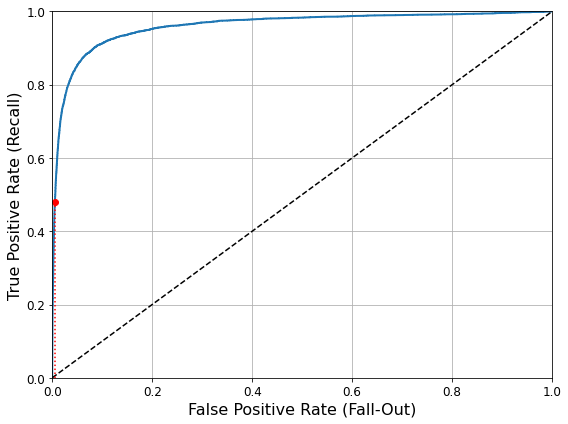

In [26]:
# You can use the roc_curve function to compute the TPR and FPR for various threshold values.
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Now to plot the curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

As before there is another tradeoff. The higher the TPR the higher the FPR. The dotted line represents a completely random classifier (the worst possible model) and the goal is to be as far to the top left corner as possible. One way to compare classifiers is to take the area under the curve. A perfect classifier will have an area of 1 while a perfectly random model will have an area of 0.5. We can compute the area using the roc_auc_score function. The goal is to get to as close to 1 as possible. Before moving on to comparing two models using the ROC curve we should figure out which method to use (PR curve vs ROC curve). 

> As a rule of thumb, prefer the PR curve whenever the positive class is rare or when you care more about the false positives over the false negatives. Otherwise use the ROC curve.


Below will be some code to train a RandomForestClassifier and we will compare it on a ROC curve to the current model (SGD classifier). 

Saving figure roc_curve_comparison_plot


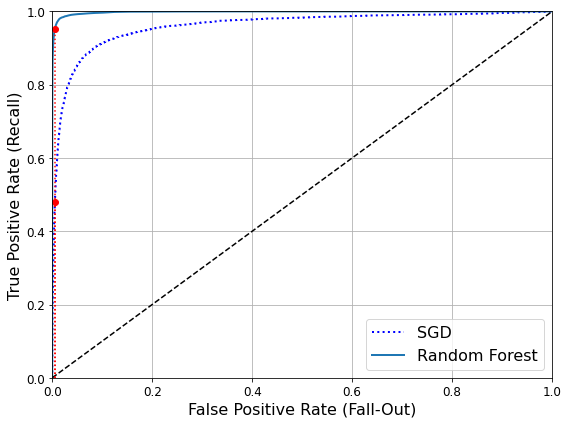

In [30]:
# Important to note that Random Forest doesn't have a decision_function instead it has a predict prob method.
# This method contains an array with the probability that something belongs to a given class
# For example 70% chance this image is a 5
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

# roc_curve function expects labels and scores but instead we can give it class probabilities
y_scores_forest = y_probas_forest[:, 1] # score = proba of a given class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Now to plot it all out
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

From this graph we can see that the Random Forest Classifier model is stronger than the SGD classifier as it is closer to the top left corner. Let's check the AUC score to be sure.

In [33]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5, y_scores))
print(roc_auc_score(y_train_5, y_scores_forest))

0.9604938554008616
0.9983436731328145


As we can see here the AUC score for the Random Forest is higher than the score fpr the SGD classifier. Since it is closer to one it must be the better model.

## Multiclass Classification

The previous models could only tell us whether an image was a 5 or not a 5. To train a model to read 0-9 we must make a multiclass classifier. There are a number of strategies to turn a binary classifier into a multiclass classifier. The two we'll focus on here are OvR and OvO. 

#### OvR (One vs Rest)

OvR strategy is rather simple and involves training 10 different binary classifiers and essentially running your image through all 10 and choosing the one where it scores the highest. These are best for large datasets as the other involves a lot of computation.


#### OvO (One vs One)

OvO strategy involves training a binary classifier between each class. Basically one to distinguish between 0 and 1, 0 and 2, another for 1 and 2 and so on. The issue with this pathway is that it requires you to run $ N * (N-1) / 2$ classifiers. This can be very computationally intensive so it is ideal for when the dataset is smaller or there aren't that many classes. The model runs the image through all (in this case 45) classifiers and chooses the class that wins the most duels. 

Scikit-Learn auto chooses the method depending on the algorithm. The code below will train a Support Vector Machine that uses the OvO strategy.

In [34]:
# Same syntax as previous models. Import SVC (support vector classifier)
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit]) # Correctly identifies that this is a 5

array([5], dtype=uint8)

In [35]:
# This code will show us the scores for each class when you run the image through
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores # Notice that the highest value corresponds to the number 5 (start at 0)

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [36]:
# To use a OvR strategy simply import OneVsRestClassifier and run it the same way
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit]) # Correctly identifies that this is a 5

array([5], dtype=uint8)

This time let's do the same thing but on an SGD Classifier. Then we'll call the decision_vunction to see the scores.

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [42]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Unfortunately this model is confused and incorrectly identifies this as a 3. As we can see in the decision function it gives the digit 3 a score of 1823 and the next highest score is 5 with -1385. Let's evaluate the performance using a cross-validation rather than just relying on this example. 

In [39]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

This model gets over 87% on all test folds which is pretty good. Remember a random classifier would score 10% so obviousl this model must be doing something right. As shown in my previous project we can improve this score by scaling the inputs using a Standast Scaler. Below we'll do just that.

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

This version gets almost 90% which is even better than the previous model. The last step for this project is to do an error analysis and possibly come back here to do more model tuning.